# BERT TRAINING WITH PYTORCH

## Required Libraries and Definitions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re # Regular expressions for text cleaning (use cautiously with BERT)

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, hamming_loss, accuracy_score # Accuracy is less informative for multi-label

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # if using CUDA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

MODEL_NAME = 'dbmdz/bert-base-turkish-cased'
MAX_LENGTH = 128 # Max sequence length BERT can handle (adjust based on EDA)
BATCH_SIZE = 16 # Adjust based on GPU memory
EPOCHS = 3 # Number of training epochs (BERT fine-tuning usually requires few epochs)
LEARNING_RATE = 2e-5 # Common learning rate for BERT fine-tuning

Using device: cuda


## Dataset

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/Overfit-GM/turkish-toxic-language/turkish_toxic_language.csv")

In [ ]:
df.head()

,text,target,source,is_toxic
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0


In [ ]:
df["is_toxic"].value_counts()

,count
is_toxic,
1,40137
0,37663


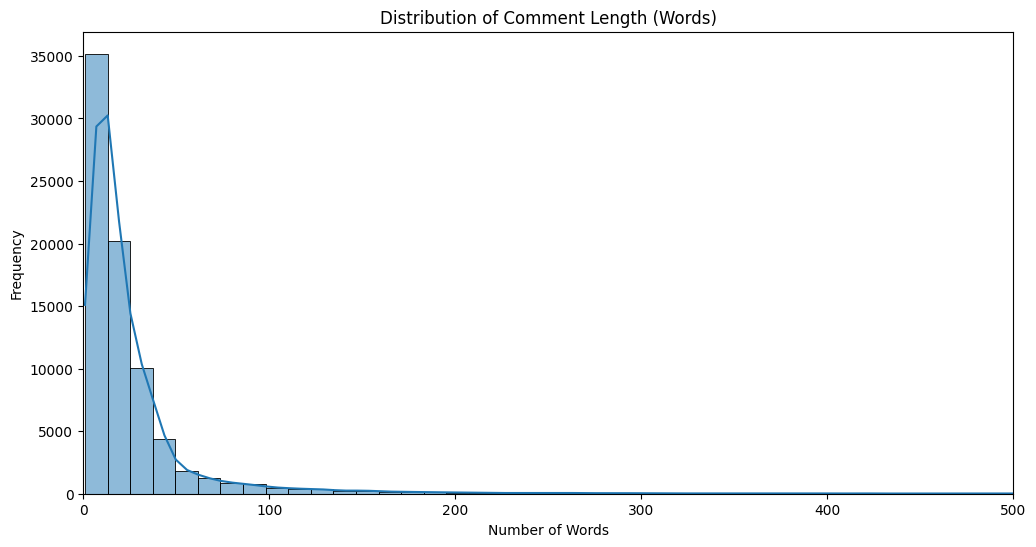


 text_length Statistics (Words):
count    77800.000000
mean        28.391118
std         54.763483
min          1.000000
25%          8.000000
50%         15.000000
75%         29.000000
max       1215.000000
Name: text_length, dtype: float64


In [ ]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=100, kde=True)
plt.title('Distribution of Comment Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# Limit x-axis for better visualization if needed
plt.xlim(0, 500)
plt.show()

print("\n text_length Statistics (Words):")
print(df['text_length'].describe())

In [ ]:
def clean_text(text):
    text = str(text)
    # Remove URLs (optional, BERT might handle some context)
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Basic handling of common issues if needed
    # text = text.lower() # BERT uncased models handle this
    return text

# Apply cleaning (demonstrative - may skip depending on BERT variant)
# train_df['comment_text_cleaned'] = train_df['comment_text'].apply(clean_text)
# test_df['comment_text_cleaned'] = test_df['comment_text'].apply(clean_text)
# Use original text for now as BERT benefits from closer-to-raw text
df['text_cleaned'] = df['text']

## Tokenizer Example

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Example tokenization
sample_text = "hepinize merhabalar arkadaşlar nasılsınız?"
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    padding='max_length', # Pad to max_length
    truncation=True,      # Truncate longer sequences
    return_tensors='pt'   # Return PyTorch tensors
)

print("\nSample Tokenization:")
print(f"Text: {sample_text}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])}")
print(f"Input IDs: {tokens['input_ids']}")
print(f"Attention Mask: {tokens['attention_mask']}") # 1 for real tokens, 0 for padding


Sample Tokenization:
Text: hepinize merhabalar arkadaşlar nasılsınız?
Tokens: ['[CLS]', 'hepinize', 'merhabalar', 'arkadaşlar', 'nasıl', '##sınız', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([[    2, 28015, 28660,  7208,  2767,  3342,    35,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


## DataLoader

In [ ]:
class ToxicCommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,
            return_token_type_ids=False, # Not needed for basic BERT classification
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', # Return PyTorch tensors
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.float) # Use float for BCEWithLogitsLoss
        }

X = df['text'].values
y = df['is_toxic'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1, # Use 10% for validation
    random_state=SEED,
)

print(f"\nTrain size: {len(X_train)}, Validation size: {len(X_val)}")

train_dataset = ToxicCommentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = ToxicCommentDataset(X_val, y_val, tokenizer, MAX_LENGTH)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers depends on your system
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("\nSample batch shapes:")
print("Input IDs:", data['input_ids'].shape)
print("Attention Mask:", data['attention_mask'].shape)
print("Labels:", data['labels'].shape)


Train size: 70020, Validation size: 7780

Sample batch shapes:
Input IDs: torch.Size([16, 128])
Attention Mask: torch.Size([16, 128])
Labels: torch.Size([16])


## Model Definition

In [ ]:
# Load BertForSequenceClassification, configuring it for multi-label
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1, # Number of output labels = number of toxic categories
    output_attentions=False, # Optional: set to True if you want attention weights
    output_hidden_states=False, # Optional: set to True if you want hidden states
)

# Move the model to the designated device (GPU or CPU)
model.to(device)

print("\nModel loaded successfully.")
# print(model) # Uncomment to see model architecture details

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded successfully.


In [ ]:
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
total = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameter count: {total}")

Trainable parameters: 110618113
Trainable parameter count: 110618113


## Optimizer, Loss, Scheduler Definition

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * EPOCHS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Optional: set a number of warmup steps (e.g., 0.1 * total_steps)
    num_training_steps=total_steps
)

# Loss function for multi-label classification
# BCEWithLogitsLoss combines a Sigmoid layer and Binary Cross Entropy loss in one class.
# It's numerically more stable than using a plain Sigmoid followed by BCE Loss.
loss_fn = nn.BCEWithLogitsLoss().to(device)

## Train Function

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, batch in enumerate(data_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits # Raw model output (before sigmoid)

        # Calculate loss
        loss = loss_fn(logits, labels.unsqueeze(1))
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients (common practice)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step() # Update learning rate

        # Print progress (optional)
        if (i + 1) % 1000 == 0:
             print(f'  Batch {i + 1}/{num_batches} | Loss: {loss.item():.4f}')


    avg_train_loss = total_loss / num_batches
    print(f"\n  Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss

## Evaluation Function

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = len(data_loader)

    with torch.no_grad(): # Disable gradient calculation
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits

            loss = loss_fn(logits, labels.unsqueeze(1))
            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_val_loss = total_loss / num_batches
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    roc_auc_scores = {}
    mean_roc_auc = 0
    try:
        for i in range(all_preds.shape[1]):
            roc_auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            roc_auc_scores[f"Label {i}"] = roc_auc

    except Exception as e:
        print(f"  Could not calculate ROC AUC: {e}")

    threshold = 0.5
    binary_preds = (all_preds > threshold).astype(int)
    hamming = hamming_loss(all_labels, binary_preds)
    print(f"  Hamming Loss: {hamming:.4f}")

    # (Optional) You can also calculate Micro/Macro F1 scores or Accuracy (less useful)
    # print("\nClassification Report (threshold=0.5):")
    # print(classification_report(all_labels, binary_preds, target_names=label_cols, zero_division=0))

    return avg_val_loss, mean_roc_auc, hamming # Return key metrics

## Training

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'val_roc_auc': [], 'val_hamming': []}
best_roc_auc = -1
best_model_state = None

print("\nStarting Training...")
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )
    history['train_loss'].append(train_loss)

    print(f"\n--- Validation Epoch {epoch + 1} ---")
    val_loss, val_roc_auc, val_hamming = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device
    )
    history['val_loss'].append(val_loss)
    history['val_roc_auc'].append(val_roc_auc)
    history['val_hamming'].append(val_hamming)

    # Save the best model based on validation ROC AUC
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model_state.bin')
        print(f"  ** New best model saved with ROC AUC: {best_roc_auc:.4f} **")

print("\nTraining Finished.")
print(f"Best Validation ROC AUC: {best_roc_auc:.4f}")

# Load the best model state for prediction
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model state for prediction.")


Starting Training...

--- Epoch 1/3 ---
  Batch 100/4377 | Loss: 0.2311
  Batch 200/4377 | Loss: 0.2501
  Batch 300/4377 | Loss: 0.0745
  Batch 400/4377 | Loss: 0.1351
  Batch 500/4377 | Loss: 0.1678
  Batch 600/4377 | Loss: 0.2320
  Batch 700/4377 | Loss: 0.0117
  Batch 800/4377 | Loss: 0.0018
  Batch 900/4377 | Loss: 0.2737
  Batch 1000/4377 | Loss: 0.0970
  Batch 1100/4377 | Loss: 0.0243
  Batch 1200/4377 | Loss: 0.1397
  Batch 1300/4377 | Loss: 0.3009
  Batch 1400/4377 | Loss: 0.0286
  Batch 1500/4377 | Loss: 0.2805
  Batch 1600/4377 | Loss: 0.0050
  Batch 1700/4377 | Loss: 0.1498
  Batch 1800/4377 | Loss: 0.0016
  Batch 1900/4377 | Loss: 0.0646
  Batch 2000/4377 | Loss: 0.0081
  Batch 2100/4377 | Loss: 0.0032
  Batch 2200/4377 | Loss: 0.0026
  Batch 2300/4377 | Loss: 0.2876
  Batch 2400/4377 | Loss: 0.0112
  Batch 2500/4377 | Loss: 0.0318
  Batch 2600/4377 | Loss: 0.0029
  Batch 2700/4377 | Loss: 0.0023
  Batch 2800/4377 | Loss: 0.1752
  Batch 2900/4377 | Loss: 0.1712
  Batch 300

KeyboardInterrupt: 

## Prediction

In [ ]:
import torch

text = "kötü kokuyorsun."

encoding = tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

model.eval()

with torch.no_grad():
    output = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = output.logits
    probs = torch.sigmoid(logits)

print("Logits:", logits.item())
print("Olasılık (toksik olma ihtimali):", probs.item())

threshold = 0.5
predicted_label = int(probs.item() > threshold)
print("Tahmin edilen sınıf:", predicted_label)

Logits: 10.020668029785156
Olasılık (toksik olma ihtimali): 0.9999555349349976
Tahmin edilen sınıf: 1


# BERT TRAINING WITH HUGGINGFACE TRAINER


## Dataset Preparation

In [ ]:
import pandas as pd

df = pd.read_csv("hf://datasets/Overfit-GM/turkish-toxic-language/turkish_toxic_language.csv")

In [ ]:
df.head()

,text,target,source,is_toxic
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0


In [ ]:
df['is_toxic'].value_counts()

,count
is_toxic,
1,40137
0,37663


In [ ]:
from sklearn.utils import resample

df_0 = df[df['is_toxic'] == 0]
df_1 = df[df['is_toxic'] == 1]

min_count = min(len(df_0), len(df_1))

df_0_downsampled = resample(df_0, replace=False, n_samples=min_count, random_state=42)
df_1_downsampled = resample(df_1, replace=False, n_samples=min_count, random_state=42)

df_balanced = pd.concat([df_0_downsampled, df_1_downsampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df = df_balanced.copy()

In [ ]:
from sklearn.model_selection import train_test_split
import re

def clean_text(text):
    text = str(text)
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Harfler dışındaki her şeyi sil (sadece Türkçe ve İngilizce harfleri tut)
    text = re.sub(r'[^a-zA-ZçÇğĞıİöÖşŞüÜ\s]', '', text)

    # Birden fazla boşluğu teke indir ve baş/son boşlukları temizle
    text = re.sub(r'\s+', ' ', text).strip()

    return text


df['text_cleaned'] = df['text']

df = df.drop(columns=['text', 'target', "source"])
df["text"] = df["text_cleaned"]
df = df.rename(columns={"is_toxic": "label"})
df = df[["text", "label"]]
df.head()

,text,label
0,Mea Culpa Bunu işaret ettiğiniz için teşekkürler,0
1,Hayır belki değil çünkü eğer denersem davamın ...,0
2,İki tosunun resmini görmek isterim¿,0
3,Termoplastik Kauçuk Sana daha önce söylemeliyd...,0
4,Bilinen bir gerçeği belirtmek için beni engell...,1


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/75326 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset = tokenized_dataset.map(lambda x: {"labels": float(x["labels"])})

Map:   0%|          | 0/75326 [00:00<?, ? examples/s]

In [ ]:
from datasets import Value
tokenized_dataset = tokenized_dataset.cast_column("labels", Value("float32"))

Casting the dataset:   0%|          | 0/75326 [00:00<?, ? examples/s]

In [ ]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

## Model

In [ ]:
from transformers import AutoModelForSequenceClassification

model_name = "dbmdz/bert-base-turkish-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

print(model.config)



model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.53.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



In [ ]:
for param in model.bert.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 110618113


custom bert if you want to use

In [ ]:
import torch.nn as nn

class CustomBERTModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(output[1])  # Applying dropout
        logits = self.fc(pooled_output)  # Adding a fully connected layer
        return logits

# Initialize the custom model
custom_model = CustomBERTModel("dbmdz/bert-base-turkish-cased", num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Arguments

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving model checkpoints
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    # eval_steps=500,
    save_strategy="epoch",
    learning_rate=5e-5,              # Start with a small learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=4,              # Number of epochs
    weight_decay=0.01,               # Regularization
    save_total_limit=2,              # Limit checkpoints to save space
    load_best_model_at_end=True,     # Automatically load the best checkpoint
    metric_for_best_model="f1",
    logging_dir="./logs",            # Directory for logs
    logging_steps=100,               # Log every 100 steps
    fp16=True                        # Enable mixed precision for faster training
)
# training_args = TrainingArguments(
#     output_dir="./bert-binary",
#     eval_strategy="steps",
#     eval_steps=50,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=5,
#     logging_steps=10,
#     save_total_limit=2,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     greater_is_better=True
# )

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds)
    }


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Training

In [ ]:
from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,                        # Pre-trained BERT model
    args=training_args,                 # Training arguments
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,        # Efficient batching
    compute_metrics=compute_metrics,     # Custom metric
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping
)

# Start training
trainer.train()

/tmp/ipython-input-17-1041615943.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ckryusuff (ckryusuff-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.044200,0.032597,0.505111,0.671194
2,0.022200,0.033696,0.939068,0.942474
3,0.012700,0.030285,0.575601,0.704118
4,0.008500,0.029567,0.957255,0.959054


TrainOutput(global_step=16952, training_loss=0.027621367878582524, metrics={'train_runtime': 2537.7248, 'train_samples_per_second': 106.856, 'train_steps_per_second': 6.68, 'total_flos': 1.7836927624006656e+16, 'train_loss': 0.027621367878582524, 'epoch': 4.0})

## Save to HF

In [ ]:
from huggingface_hub import login
login()
trainer.push_to_hub("turkish-toxic-comment-classifier")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/cakiryusuff/results/commit/c7a5a5ed6ede91207e593af71320c004341479b3', commit_message='turkish-toxic-comment-classifier', commit_description='', oid='c7a5a5ed6ede91207e593af71320c004341479b3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/cakiryusuff/results', endpoint='https://huggingface.co', repo_type='model', repo_id='cakiryusuff/results'), pr_revision=None, pr_num=None)

## Prediction

In [ ]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch
import torch.nn.functional as F

def predict(text, threshold=0.6):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits

    # Apply sigmoid instead of softmax
    probs = torch.sigmoid(logits)

    print(probs)
    # Convert probabilities to binary predictions using threshold
    predictions = (probs > threshold).int()
    print(predictions)

    # Return prediction indices of classes where prediction == 1
    predicted_classes = predictions.squeeze()

    return predicted_classes


In [ ]:
sample_text = "abi kötü oynuyorsun"
predicted_classes = predict(sample_text)

print(predicted_classes)

tensor([[0.7086]], device='cuda:0')
tensor([[1]], device='cuda:0', dtype=torch.int32)
tensor(1, device='cuda:0', dtype=torch.int32)
